# Part I: Data Preparation and Analysis

## Add all necessary imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

## Load the datasets

In [69]:
# Set paths
data_dir = 'dataset_Seminar5'
client_dir = os.path.join(data_dir, 'client_datasets')
test_features_path = os.path.join(data_dir, 'test_features.csv')
test_labels_path = os.path.join(data_dir, 'test_labels.csv')

In [70]:
# Function to load client data
def load_client_data(client_id):
    features_path = os.path.join(client_dir, f'client_{client_id}_features.csv')
    labels_path = os.path.join(client_dir, f'client_{client_id}_labels.csv')
    
    # Load features and labels
    features = pd.read_csv(features_path, header=None).values
    labels = pd.read_csv(labels_path, header=None).values.flatten()  # Flatten to 1D array
    
    return features, labels

In [71]:
# Load test data
test_features = pd.read_csv(test_features_path, header=None).values
test_labels = pd.read_csv(test_labels_path, header=None).values.flatten()

print(f"Test data shape: {test_features.shape}")
print(f"Test labels shape: {test_labels.shape}")

Test data shape: (500, 270)
Test labels shape: (500,)


In [72]:
# Load all client data
num_clients = 10
client_data = {}

for client_id in range(1, num_clients + 1):
    features, labels = load_client_data(client_id)
    client_data[client_id] = {
        'features': features,
        'labels': labels
    }
    print(f"Client {client_id} data shape: {features.shape}, labels shape: {labels.shape}")

Client 1 data shape: (314, 270), labels shape: (314,)
Client 2 data shape: (113, 270), labels shape: (113,)
Client 3 data shape: (365, 270), labels shape: (365,)
Client 4 data shape: (207, 270), labels shape: (207,)
Client 5 data shape: (209, 270), labels shape: (209,)
Client 6 data shape: (202, 270), labels shape: (202,)
Client 7 data shape: (448, 270), labels shape: (448,)
Client 8 data shape: (142, 270), labels shape: (142,)
Client 9 data shape: (412, 270), labels shape: (412,)
Client 10 data shape: (64, 270), labels shape: (64,)


## Make plots to understand the data distribution

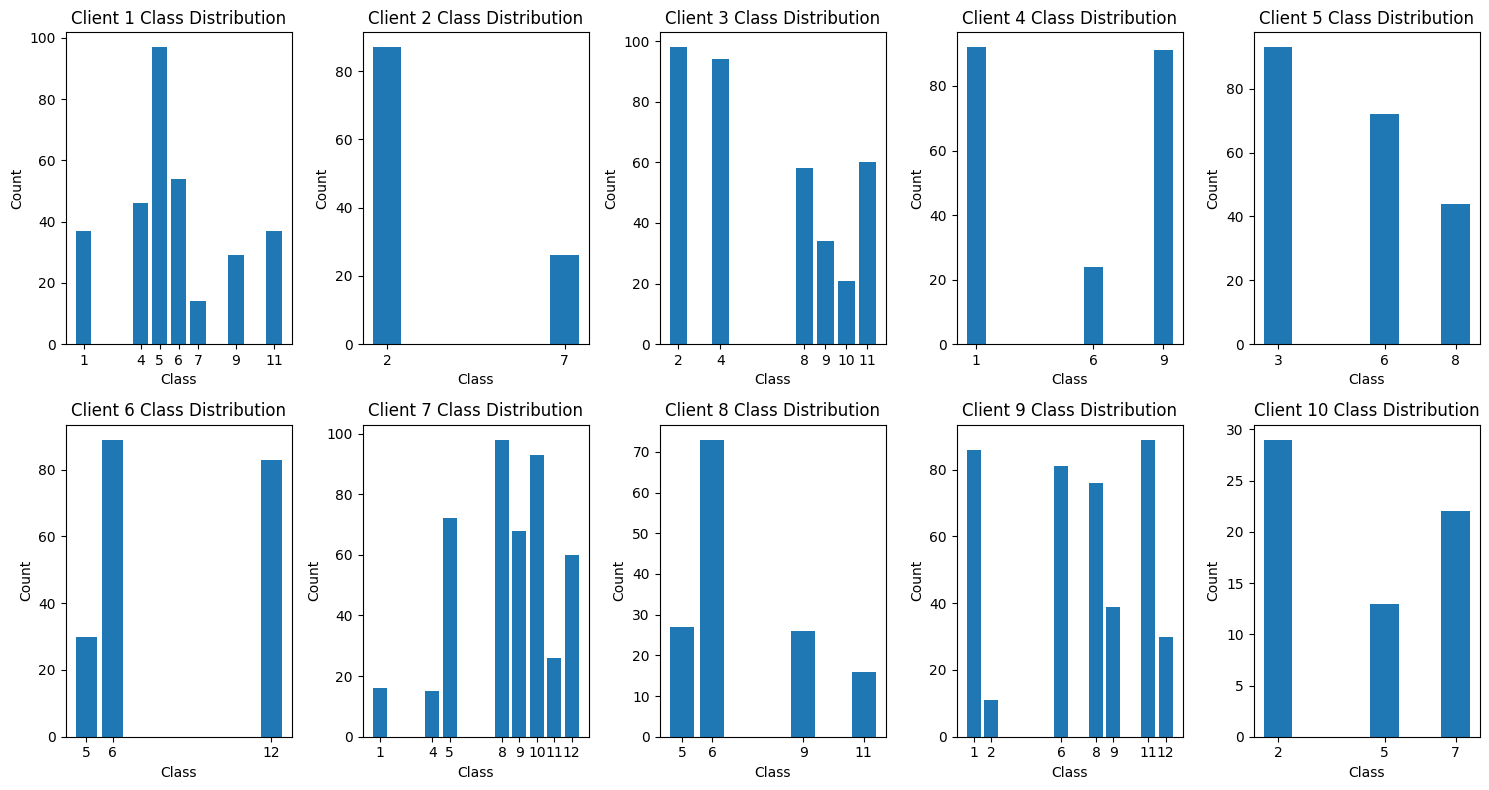

In [73]:
# Check class distribution across clients
plt.figure(figsize=(15, 8))

for client_id in range(1, num_clients + 1):
    plt.subplot(2, 5, client_id)
    unique_classes, class_counts = np.unique(client_data[client_id]['labels'], return_counts=True)
    plt.bar(unique_classes, class_counts)
    plt.title(f'Client {client_id} Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique_classes)

plt.tight_layout()
plt.show()

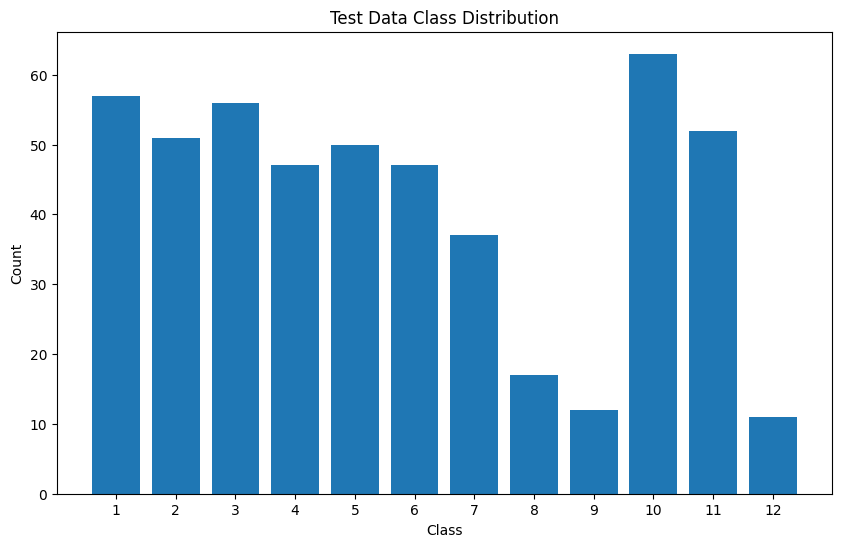

In [74]:
# Check test data distribution
plt.figure(figsize=(10, 6))
unique_classes, class_counts = np.unique(test_labels, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.title('Test Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes)
plt.show()

In [75]:
# Determine total number of classes in the dataset
all_classes = set()
for client_id in range(1, num_clients + 1):
    all_classes.update(np.unique(client_data[client_id]['labels']))
all_classes.update(np.unique(test_labels))

# Determine the minimum and maximum class IDs to handle all possible classes
min_class = min(all_classes)
max_class = max(all_classes)
num_classes = max_class + 1  # +1 because classes start from 0

print(f"Total number of unique classes: {len(all_classes)}")
print(f"Class IDs: {sorted(all_classes)}")
print(f"Setting num_classes to {num_classes} to handle all classes")

Total number of unique classes: 12
Class IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
Setting num_classes to 13 to handle all classes


## Preprocess and prepare data for training

In [76]:
# Initialize a standard scaler
scaler = StandardScaler()

# Combine all client data for fitting the scaler
all_features = np.vstack([client_data[i]['features'] for i in range(1, num_clients + 1)])
scaler.fit(all_features)

# Scale client and test data
for client_id in range(1, num_clients + 1):
    client_data[client_id]['scaled_features'] = scaler.transform(client_data[client_id]['features'])
    
# Scale test data
scaled_test_features = scaler.transform(test_features)

In [77]:
# Convert labels to PyTorch tensors
for client_id in range(1, num_clients + 1):
    client_data[client_id]['labels_tensor'] = torch.tensor(client_data[client_id]['labels'], dtype=torch.long)
    client_data[client_id]['features_tensor'] = torch.tensor(client_data[client_id]['scaled_features'], dtype=torch.float32)
    
# Convert test data to PyTorch tensors
test_features_tensor = torch.tensor(scaled_test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Part II: Model Architecture and Federated Learning Implementation

## Define Neural Network Model Architecture

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the PyTorch neural network model
class FederatedModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FederatedModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.output_layer = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x

def create_model(input_dim, num_classes):
    model = FederatedModel(input_dim, num_classes)
    return model

## Implement Federated Learning Components

Let's implement the federated learning algorithm with a focus on FedAvg (Federated Averaging).

In [79]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def train_client_model(client_id, global_model, client_data, epochs=5):
    """Train a client model on its local data starting from the global model."""
    # Get client data
    features = client_data[client_id]['features_tensor']
    labels = client_data[client_id]['labels_tensor']
    
    # Create a local model with the same weights as the global model
    input_dim = features.shape[1]
    local_model = create_model(input_dim, num_classes)
    
    # Copy weights from global model to local model
    local_model.load_state_dict(copy.deepcopy(global_model.state_dict()))
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(local_model.parameters(), lr=0.001)
    
    # Create DataLoader for batching
    dataset = TensorDataset(features, labels)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Set model to training mode
    local_model.train()
    
    # Train the local model
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_features, batch_labels in train_loader:
            # Forward pass
            outputs = local_model(batch_features)
            loss = criterion(outputs, batch_labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
    
    return local_model

In [80]:
import copy
import numpy as np
import torch

def federated_averaging(global_model, client_models, client_data):
    """Aggregate client models using weighted federated averaging."""
    # Get total data size for weighting
    total_size = sum(client_data[i]['features'].shape[0] for i in range(1, len(client_models) + 1))
    
    # Initialize a dictionary to store the weighted average of model parameters
    global_dict = copy.deepcopy(global_model.state_dict())
    
    # Initialize with zeros
    for key in global_dict:
        global_dict[key] = torch.zeros_like(global_dict[key])
    
    # Weighted averaging of model parameters
    for client_id, client_model in enumerate(client_models, start=1):
        # Calculate client weight proportional to data size
        client_weight = client_data[client_id]['features'].shape[0] / total_size
        client_dict = client_model.state_dict()
        
        for key in global_dict:
            global_dict[key] += client_weight * client_dict[key]
    
    # Update global model with averaged weights
    global_model.load_state_dict(global_dict)
    
    return global_model

# Part III: Federated Learning Training and Evaluation

In [81]:
# Initialize the global model
input_dim = scaled_test_features.shape[1]  # Get feature dimension
global_model = create_model(input_dim, num_classes)

# Parameters
federated_rounds = 10
client_epochs = 5

# Track metrics
global_accuracy = []
client_accuracies = {i: [] for i in range(1, num_clients + 1)}

# Create criterion for evaluation
criterion = nn.CrossEntropyLoss()

# Function to evaluate a model
def evaluate_model(model, features, labels):
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)
        loss = criterion(outputs, labels).item()
    return loss, accuracy

# Run federated learning rounds
for round_num in range(1, federated_rounds + 1):
    print(f"\nFederated Learning Round {round_num}/{federated_rounds}")
    
    # Train each client model
    client_models = []
    for client_id in range(1, num_clients + 1):
        print(f"Training client {client_id}...")
        client_model = train_client_model(client_id, global_model, client_data, client_epochs)
        client_models.append(client_model)
        
        # Evaluate client model on test data
        client_loss, client_acc = evaluate_model(client_model, test_features_tensor, test_labels_tensor)
        client_accuracies[client_id].append(client_acc)
        print(f"Client {client_id} test accuracy: {client_acc:.4f}")
    
    # Update global model using federated averaging
    global_model = federated_averaging(global_model, client_models, client_data)
    
    # Evaluate global model on test data
    global_loss, global_acc = evaluate_model(global_model, test_features_tensor, test_labels_tensor)
    global_accuracy.append(global_acc)
    print(f"Global model test accuracy after round {round_num}: {global_acc:.4f}")


Federated Learning Round 1/10
Training client 1...
Client 1 test accuracy: 0.1720
Training client 2...
Client 2 test accuracy: 0.1020
Training client 3...
Client 3 test accuracy: 0.1760
Training client 4...
Client 4 test accuracy: 0.0900
Training client 5...
Client 5 test accuracy: 0.1440
Training client 6...
Client 3 test accuracy: 0.1760
Training client 4...
Client 4 test accuracy: 0.0900
Training client 5...
Client 5 test accuracy: 0.1440
Training client 6...
Client 6 test accuracy: 0.0780
Training client 7...
Client 7 test accuracy: 0.1720
Training client 8...
Client 8 test accuracy: 0.0940
Training client 9...
Client 6 test accuracy: 0.0780
Training client 7...
Client 7 test accuracy: 0.1720
Training client 8...
Client 8 test accuracy: 0.0940
Training client 9...
Client 9 test accuracy: 0.2220
Training client 10...
Client 10 test accuracy: 0.0900
Global model test accuracy after round 1: 0.0980

Federated Learning Round 2/10
Training client 1...
Client 9 test accuracy: 0.2220
Tra

## Visualize Federated Learning Results

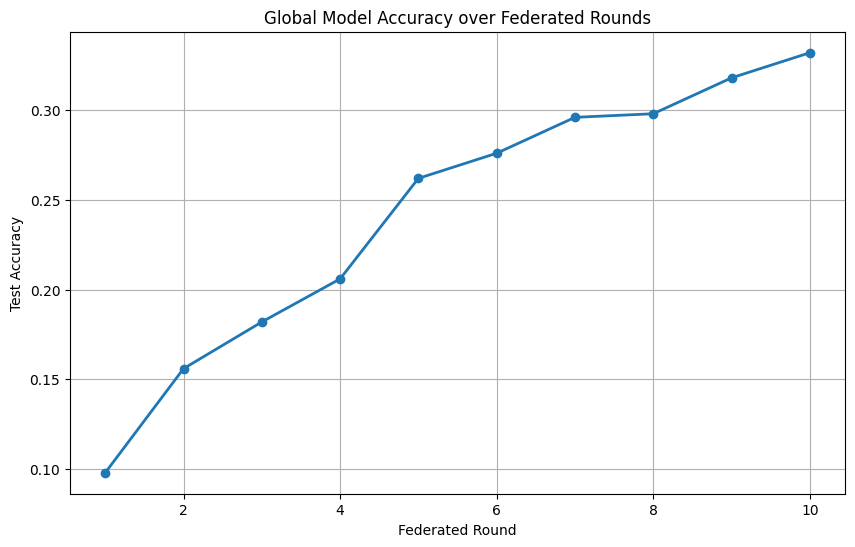

In [82]:
# Plot global model accuracy over federated rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, federated_rounds + 1), global_accuracy, marker='o', linestyle='-', linewidth=2)
plt.title('Global Model Accuracy over Federated Rounds')
plt.xlabel('Federated Round')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

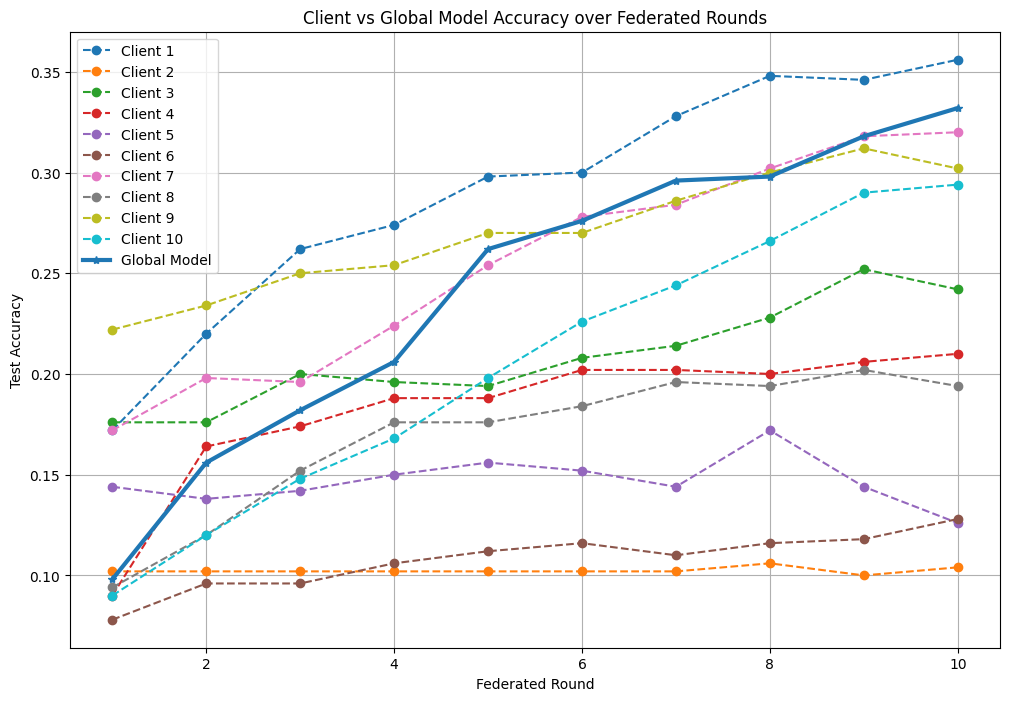

In [83]:
# Plot client model accuracies over federated rounds
plt.figure(figsize=(12, 8))

for client_id in range(1, num_clients + 1):
    plt.plot(range(1, federated_rounds + 1), client_accuracies[client_id], marker='o', linestyle='--', label=f'Client {client_id}')

plt.plot(range(1, federated_rounds + 1), global_accuracy, marker='*', linestyle='-', linewidth=3, label='Global Model')
plt.title('Client vs Global Model Accuracy over Federated Rounds')
plt.xlabel('Federated Round')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Final Model Evaluation and Analysis

Let's evaluate the final global model on the test dataset and analyze its performance in detail.

In [84]:
# Make predictions with the final global model
global_model.eval()
with torch.no_grad():
    test_outputs = global_model(test_features_tensor)
    _, predicted_classes = torch.max(test_outputs, 1)
    predicted_classes = predicted_classes.numpy()

# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_classes)
print(f"Final Global Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_classes))

Final Global Model Accuracy: 0.3320

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.54      0.61        57
           2       1.00      0.02      0.04        51
           3       0.00      0.00      0.00        56
           4       0.44      0.30      0.35        47
           5       0.65      0.40      0.49        50
           6       0.23      0.89      0.36        47
           7       0.00      0.00      0.00        37
           8       0.22      0.47      0.30        17
           9       0.17      1.00      0.29        12
          10       0.00      0.00      0.00        63
          11       0.38      0.67      0.49        52
          12       0.43      0.27      0.33        11

    accuracy                           0.33       500
   macro avg       0.35      0.38      0.27       500
weighted avg       0.37      0.33      0.27       500



/Users/marcsirventruiz/University/ML_NETWORKS/SEMINARS/ML4NETvenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcsirventruiz/University/ML_NETWORKS/SEMINARS/ML4NETvenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcsirventruiz/University/ML_NETWORKS/SEMINARS/ML4NETvenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

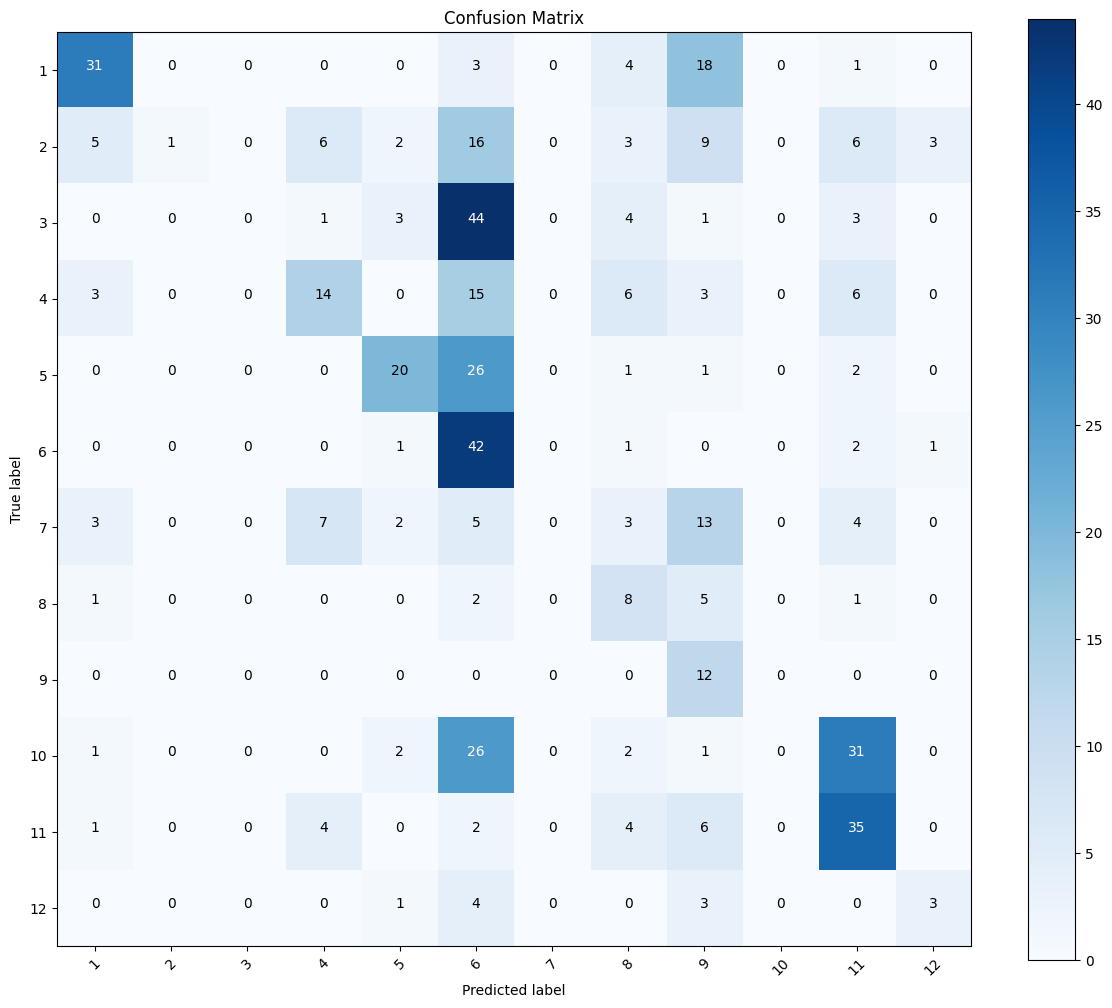

In [85]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, predicted_classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = sorted(list(all_classes))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add text annotations to the confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Part IV: Comparison with Centralized Learning

Let's compare the federated learning approach with centralized learning to understand the trade-offs.

In [86]:
# Combine all client data for centralized learning
centralized_features = np.vstack([client_data[i]['scaled_features'] for i in range(1, num_clients + 1)])
centralized_labels = np.concatenate([client_data[i]['labels'] for i in range(1, num_clients + 1)])

print(f"Centralized data shape: {centralized_features.shape}, labels shape: {centralized_labels.shape}")

Centralized data shape: (2476, 270), labels shape: (2476,)


In [87]:
# Create and train centralized model
centralized_model = create_model(input_dim, num_classes)

# Convert all data to PyTorch tensors
centralized_features_tensor = torch.tensor(centralized_features, dtype=torch.float32)
# Create a stacked tensor of all one-hot labels
centralized_labels_tensor = torch.cat([client_data[i]['labels_tensor'] for i in range(1, num_clients + 1)])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(centralized_model.parameters(), lr=0.001)

# Set up DataLoader for batching
dataset = TensorDataset(centralized_features_tensor, centralized_labels_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training history
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Train the centralized model
total_epochs = federated_rounds * client_epochs
for epoch in range(total_epochs):
    # Training phase
    centralized_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = centralized_model(batch_features)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()
    
    # Validation phase
    centralized_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            outputs = centralized_model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += batch_labels.size(0)
            val_correct += (predicted == batch_labels).sum().item()
    
    # Calculate epoch metrics
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total
    
    # Store history
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(val_loader))
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_accuracy)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{total_epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Acc: {val_accuracy:.4f}")

Epoch 5/50, Train Loss: 1.4375, Train Acc: 0.5137, Val Loss: 1.6938, Val Acc: 0.3900
Epoch 10/50, Train Loss: 1.0560, Train Acc: 0.6502, Val Loss: 1.4288, Val Acc: 0.4940
Epoch 10/50, Train Loss: 1.0560, Train Acc: 0.6502, Val Loss: 1.4288, Val Acc: 0.4940
Epoch 15/50, Train Loss: 0.8657, Train Acc: 0.6971, Val Loss: 1.3202, Val Acc: 0.5460
Epoch 15/50, Train Loss: 0.8657, Train Acc: 0.6971, Val Loss: 1.3202, Val Acc: 0.5460
Epoch 20/50, Train Loss: 0.7273, Train Acc: 0.7528, Val Loss: 1.2365, Val Acc: 0.6140
Epoch 20/50, Train Loss: 0.7273, Train Acc: 0.7528, Val Loss: 1.2365, Val Acc: 0.6140
Epoch 25/50, Train Loss: 0.6494, Train Acc: 0.7771, Val Loss: 1.1991, Val Acc: 0.6400
Epoch 25/50, Train Loss: 0.6494, Train Acc: 0.7771, Val Loss: 1.1991, Val Acc: 0.6400
Epoch 30/50, Train Loss: 0.5658, Train Acc: 0.8074, Val Loss: 1.1640, Val Acc: 0.6560
Epoch 30/50, Train Loss: 0.5658, Train Acc: 0.8074, Val Loss: 1.1640, Val Acc: 0.6560
Epoch 35/50, Train Loss: 0.5012, Train Acc: 0.8279, Val

In [88]:
# Evaluate centralized model
centralized_model.eval()
with torch.no_grad():
    outputs = centralized_model(test_features_tensor)
    _, predicted = torch.max(outputs, 1)
    centralized_acc = (predicted == test_labels_tensor).sum().item() / test_labels_tensor.size(0)
    centralized_loss = criterion(outputs, test_labels_tensor).item()

print(f"Centralized Model Accuracy: {centralized_acc:.4f}")
print(f"Federated Model Accuracy: {global_accuracy[-1]:.4f}")

Centralized Model Accuracy: 0.6720
Federated Model Accuracy: 0.3320


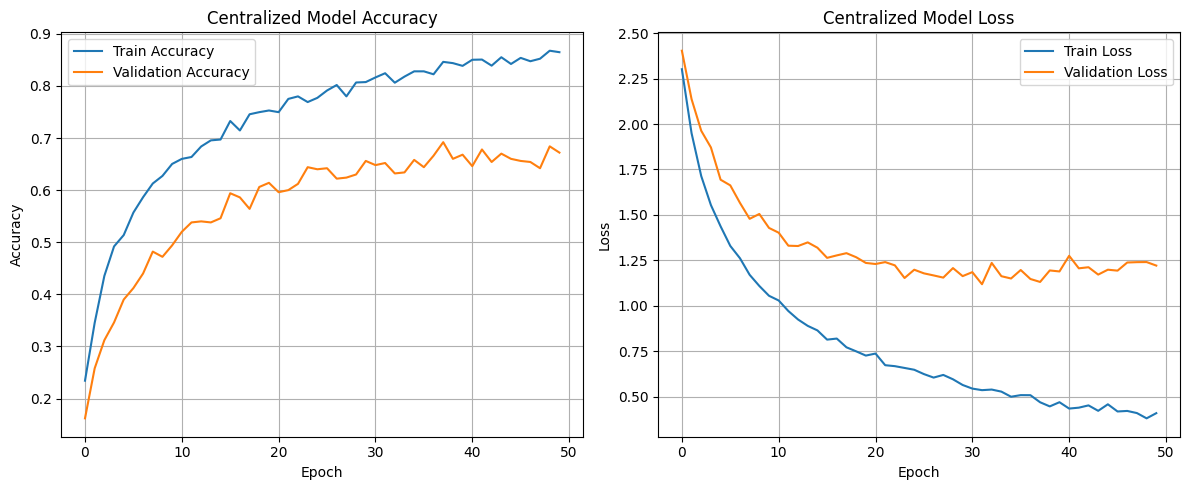

In [89]:
# Plot training history for centralized model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Centralized Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Centralized Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Part V: Federated Learning with Enhanced Privacy

In real federated learning systems, data never leaves the client devices. Let's simulate this by implementing a version where we can't directly access client data.

In [90]:
class FederatedClient:
    def __init__(self, client_id, data):
        self.client_id = client_id
        self.features = data['features_tensor']
        self.labels = data['labels_tensor']
        self.data_size = self.features.shape[0]
        
    def train_local_model(self, global_weights, input_dim, num_classes, epochs=5):
        # Create local model
        local_model = create_model(input_dim, num_classes)
        local_model.load_state_dict(copy.deepcopy(global_weights))
        
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(local_model.parameters(), lr=0.001)
        
        # Create DataLoader
        dataset = TensorDataset(self.features, self.labels)
        train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        
        # Train the model
        local_model.train()
        for epoch in range(epochs):
            for batch_features, batch_labels in train_loader:
                # Forward pass
                outputs = local_model(batch_features)
                loss = criterion(outputs, batch_labels)
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Return updated weights and data size (for weighted averaging)
        return local_model.state_dict(), self.data_size

In [91]:
def federated_learning_with_privacy(num_clients, client_data, input_dim, num_classes, federated_rounds=10, client_epochs=5):
    # Create global model
    global_model = create_model(input_dim, num_classes)
    global_weights = global_model.state_dict()
    
    # Create client objects
    federated_clients = [FederatedClient(i, client_data[i]) for i in range(1, num_clients + 1)]
    
    # Track accuracy
    global_accuracy = []
    
    # Create criterion for evaluation
    criterion = nn.CrossEntropyLoss()
    
    # Run federated learning rounds
    for round_num in range(1, federated_rounds + 1):
        print(f"\nPrivacy-Preserving Federated Learning Round {round_num}/{federated_rounds}")
        
        # Collect client weights and data sizes
        client_weights = []
        client_sizes = []
        
        # Train all clients
        for client in federated_clients:
            # Client trains locally and returns weights
            local_weights, data_size = client.train_local_model(
                global_weights, input_dim, num_classes, client_epochs
            )
            client_weights.append(local_weights)
            client_sizes.append(data_size)
            print(f"Client {client.client_id} trained locally with {data_size} samples")
        
        # Calculate the total data size for weighted averaging
        total_size = sum(client_sizes)
        
        # Perform federated averaging (weighted by data size)
        new_weights = copy.deepcopy(global_weights)
        
        for key in new_weights:
            new_weights[key] = torch.zeros_like(new_weights[key])
            
            for client_idx, weights in enumerate(client_weights):
                client_weight = client_sizes[client_idx] / total_size
                new_weights[key] += client_weight * weights[key]
        
        # Update global model
        global_weights = new_weights
        global_model.load_state_dict(global_weights)
        
        # Evaluate on test data
        global_model.eval()
        with torch.no_grad():
            outputs = global_model(test_features_tensor)
            _, predicted = torch.max(outputs, 1)
            global_acc = (predicted == test_labels_tensor).sum().item() / test_labels_tensor.size(0)
            global_loss = criterion(outputs, test_labels_tensor).item()
            
        global_accuracy.append(global_acc)
        print(f"Global model test accuracy after round {round_num}: {global_acc:.4f}")
    
    return global_model, global_accuracy

In [92]:
# Run privacy-preserving federated learning
privacy_model, privacy_accuracy = federated_learning_with_privacy(
    num_clients=num_clients,
    client_data=client_data,
    input_dim=input_dim,
    num_classes=num_classes,
    federated_rounds=federated_rounds,
    client_epochs=client_epochs
)


Privacy-Preserving Federated Learning Round 1/10
Client 1 trained locally with 314 samples
Client 2 trained locally with 113 samples
Client 3 trained locally with 365 samples
Client 4 trained locally with 207 samples
Client 5 trained locally with 209 samples
Client 1 trained locally with 314 samples
Client 2 trained locally with 113 samples
Client 3 trained locally with 365 samples
Client 4 trained locally with 207 samples
Client 5 trained locally with 209 samples
Client 6 trained locally with 202 samples
Client 6 trained locally with 202 samples
Client 7 trained locally with 448 samples
Client 8 trained locally with 142 samples
Client 9 trained locally with 412 samples
Client 10 trained locally with 64 samples
Global model test accuracy after round 1: 0.0760

Privacy-Preserving Federated Learning Round 2/10
Client 7 trained locally with 448 samples
Client 8 trained locally with 142 samples
Client 9 trained locally with 412 samples
Client 10 trained locally with 64 samples
Global mode

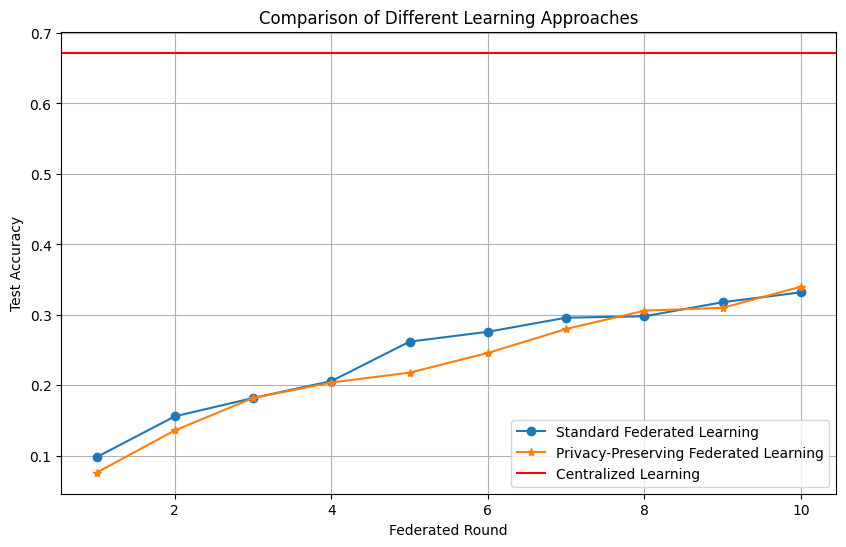

In [93]:
# Compare accuracy of different approaches
plt.figure(figsize=(10, 6))
plt.plot(range(1, federated_rounds + 1), global_accuracy, marker='o', label='Standard Federated Learning')
plt.plot(range(1, federated_rounds + 1), privacy_accuracy, marker='*', label='Privacy-Preserving Federated Learning')
plt.axhline(y=centralized_acc, color='r', linestyle='-', label='Centralized Learning')
plt.title('Comparison of Different Learning Approaches')
plt.xlabel('Federated Round')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Part VI: Conclusions and Future Work

In this seminar, we have implemented and compared different approaches to model training:

1. **Standard Federated Learning**: Training models locally on client data and aggregating them using federated averaging.
2. **Privacy-Preserving Federated Learning**: A more realistic implementation where client data stays private and only model updates are shared.
3. **Centralized Learning**: Traditional approach where all data is combined and a single model is trained.

## Key Observations
- Federated learning allows training on distributed data without sharing raw data between clients
- The privacy-preserving approach achieves similar performance to standard federated learning (~33-34% accuracy)
- Centralized learning achieves better performance (66% accuracy) due to direct access to all data
- The performance gap demonstrates the privacy-utility tradeoff in federated learning
- Depending on data heterogeneity, federated learning might perform differently compared to centralized learning

This demonstrates how federated learning can be used in privacy-sensitive scenarios while still achieving reasonable model performance. 

## Future Improvements
- Explore different aggregation methods beyond FedAvg
- Implement differential privacy to further enhance privacy guarantees
- Test performance with non-IID data distributions across clients
- Explore techniques to reduce the performance gap between federated and centralized learning